<a href="https://colab.research.google.com/github/marianadc01/pml-assignments/blob/main/Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mariana Dias Coelho (25605)

Curricular Unit - Practical Machine Learning

MSc in Green Data Science

**Assignment 6**

3 minute video + upload to Moodle

What to do:
  - Adapt the Script that implements a convolutional neural network (CNN) with PyTorch over the mnist 8 by 8 practice data set available on Overview notebook to classify images from the CIFAR-10 data set which contains 60000 32x32 color images.


**Original code from ML_overview_with_examples**

Number of examples in training set: torch.Size([1437, 64])
Number of examples in test set: torch.Size([360, 64])


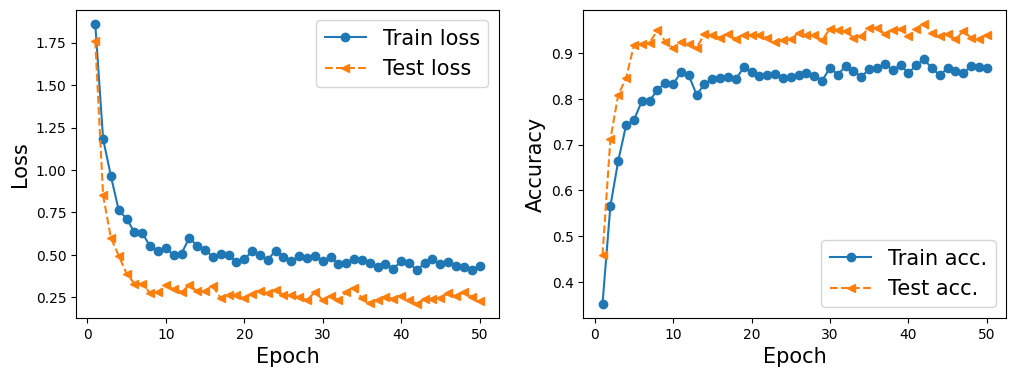

Accuracy on test set: 0.9252


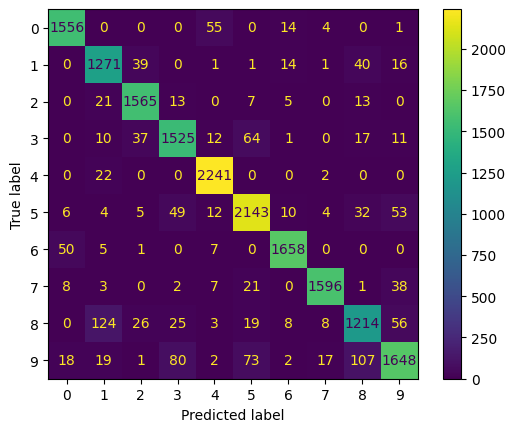

In [ ]:
#@title Improved (more modular) script that implements a neural network with PyTorch over the mnist 8 by 8 practice data set
# code adapted from https://github.com/rasbt/machine-learning-book/blob/main/ch14/ch14_part1.py

'''
This code does the following:
    Splits the dataset into training and testing sets.
    Standardizes the features using StandardScaler.
    Reshapes dataset to fit the model
    Instantiates the model (NN)
    Defines the loss function (Cross Entropy Loss) and optimizer (Adam).
    Trains the model for num_epochs epochs.
    Tests the trained model on the test set and evaluates the accuracy.
'''

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_digits # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import numpy as np

########################################################################### my functions

def train(model, optimizer, loss_fn, num_epochs, train_dl, valid_dl):
    '''
    Main function to train and test the model
    '''
    # lists to strore losses and accuracies
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    # main loop through epochs
    for epoch in range(num_epochs):
        # training mode
        model.train()
        for x_batch, y_batch in train_dl:
            # core of the learning process: predict and fit
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # compute train loss and accuracy
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        # compute average loss per epoch
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        # we also put the model in evaluation mode, so that specific layers such as dropout or batch normalization layers behave correctly.
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                # predict
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
                if epoch==0:
                    preds,actuals=torch.argmax(pred, dim=1),y_batch
                else:
                    preds=torch.cat((preds,torch.argmax(pred, dim=1)),dim=0)
                    actuals=torch.cat((actuals,y_batch),dim=0)
        # compute average loss per epoch
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        # print accuracy
        if (epoch+1) % 100==0:
            print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid, preds,actuals


def plot_accuracy_from_predictions(hist):
    ''' Creates and prints confusion matrix from a model and a set of examples
    Inputs
    ------
    hist: tuple
        where hist[4] is the list of predicted values for test and hist[5] are the actual labels
    '''
    pred=hist[4].numpy()
    actual=hist[5].numpy()
    labels = np.unique(actual)
    disp = ConfusionMatrixDisplay.from_predictions(actual,pred,labels=labels)
    # print global accuracy
    accuracy=np.sum(np.diagonal(disp.confusion_matrix))/np.sum(disp.confusion_matrix)
    print(f'Accuracy on test set: {accuracy:.4f}')
    plt.show()

def plot_losses(hist):
    ''' plots train and test loss
    Input
    ------
    history, the output of function train()
    '''
    x_arr = np.arange(len(hist[0])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Test loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Test acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

################################################################################ Data and parameters

SHOW=False # returns picture of a randomly chosen digit

examples = load_digits() # https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html; 10 digits;  1797 examples
if SHOW:
    idx=random.randint(0,len(examples.target))
    print(examples.data[idx])
    print(examples.data[idx].reshape(8,8))
    print(examples.target[idx])
    plt.matshow(examples.data[idx].reshape(8,8), cmap=plt.cm.gray_r)
    plt.show()

X = examples.data # np.ndarray (1797, 64)
y = examples.target # (1797,)

# parameter constants
test_size=0.2
hidden_size = 8
batch_size= 256
num_epochs = 50
# Optimizer specific options
learning_rate=0.1
regularization_param=0.001
# Dropout: if p>0
dropout_p=0.1 # During training, randomly zeroes some of the elements of the input tensor with probability p.

########################################################################### train and test, pre-processing
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
print('Number of examples in training set:',X_train_tensor.shape)
print('Number of examples in test set:', X_test_tensor.shape)

# Instantiate the model
input_size = X_train_tensor.shape[1]
output_size = len(examples.target_names)

# Create dataloader with batch_size
train_dl=DataLoader(TensorDataset(X_train_tensor,y_train_tensor), batch_size, shuffle=True)
test_dl=DataLoader(TensorDataset(X_test_tensor,y_test_tensor), batch_size, shuffle=False)

###################################################################################### NN model
model=nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=dropout_p),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size),
    nn.ReLU(),
    nn.Dropout(p=dropout_p),
    nn.Linear(hidden_size, output_size)
)

# Define loss function and optimizer
# Either torch.nn.NLLLoss or torch.nn.CrossEntropyLoss can be used: CrossEntropyLoss (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) implements softmax internally
loss_fn = nn.CrossEntropyLoss()

# Optimizer: optimizer object that will hold the current state and will update the parameters based on the computed gradients
# for param in model.parameters(): print(param.data)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization_param)

# Train the model and predict on test samples to estimate accuracy
# history stores losses, accuracy, actual labels and predictions
history = train(model, optimizer, loss_fn, num_epochs, train_dl, test_dl)

# plot losses along epochs
plot_losses(history)
# plot confusion matrix
plot_accuracy_from_predictions(history)
#plot_accuracy(hist)

**New code for the assignment**

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5, Train Loss: 1.6045, Train Accuracy: 0.4092, Valid Loss: 1.6003, Valid Accuracy: 0.4069
Epoch 2/5, Train Loss: 1.4456, Train Accuracy: 0.4693, Valid Loss: 1.4505, Valid Accuracy: 0.4685
Epoch 3/5, Train Loss: 1.3617, Train Accuracy: 0.5099, Valid Loss: 1.3802, Valid Accuracy: 0.5027
Epoch 4/5, Train Loss: 1.3023, Train Accuracy: 0.5319, Valid Loss: 1.3283, Valid Accuracy: 0.5194
Epoch 5/5, Train Loss: 1.2230, Train Accuracy: 0.5641, Valid Loss: 1.2707, Valid Accuracy: 0.5414


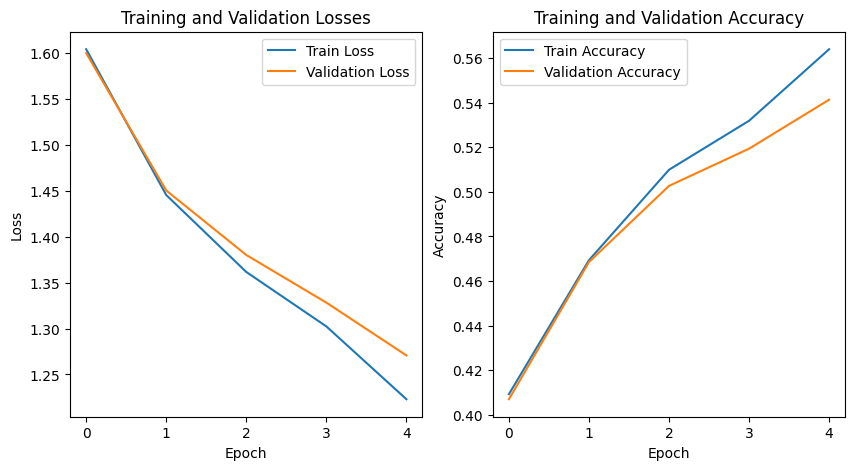

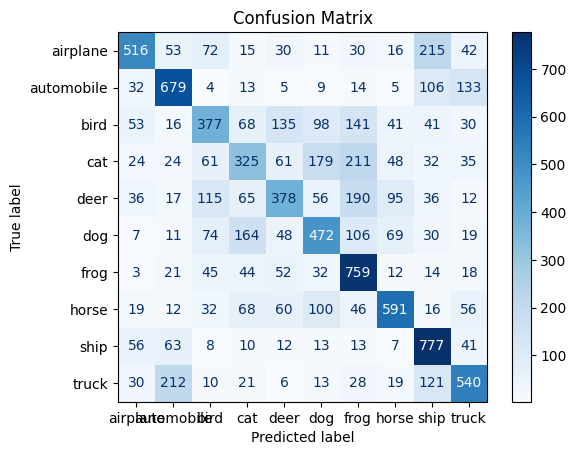

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

########################################################################### my functions

def train(model, optimizer, loss_fn, num_epochs, train_dl, valid_dl):
    '''
    Main function to train and test the model
    '''
    # Lists to store losses and accuracies
    loss_hist_train = []
    accuracy_hist_train = []
    loss_hist_valid = []
    accuracy_hist_valid = []

    # Main loop through epochs
    for epoch in range(num_epochs):
        # Training mode
        model.train()
        for x_batch, y_batch in train_dl:
            # Core of the learning process: predict and fit
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()

        # Compute train loss and accuracy
        model.eval()
        with torch.no_grad():
            train_loss = 0.0
            train_correct = 0
            for x_batch, y_batch in train_dl:
                pred = model(x_batch)
                train_loss += loss_fn(pred, y_batch).item() * y_batch.size(0)
                _, predicted = torch.max(pred, 1)
                train_correct += (predicted == y_batch).sum().item()
            train_loss /= len(train_dl.dataset)
            train_accuracy = train_correct / len(train_dl.dataset)
            loss_hist_train.append(train_loss)
            accuracy_hist_train.append(train_accuracy)

        # Validation
        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            valid_correct = 0
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                valid_loss += loss_fn(pred, y_batch).item() * y_batch.size(0)
                _, predicted = torch.max(pred, 1)
                valid_correct += (predicted == y_batch).sum().item()
            valid_loss /= len(valid_dl.dataset)
            valid_accuracy = valid_correct / len(valid_dl.dataset)
            loss_hist_valid.append(valid_loss)
            accuracy_hist_valid.append(valid_accuracy)

        # Print accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


def plot_losses_and_accuracy(loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid):
    ''' Plots train and validation losses
    Input:
    hist: tuple
    '''
    import matplotlib.pyplot as plt

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_hist_train, label='Train Loss')
    plt.plot(loss_hist_valid, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_hist_train, label='Train Accuracy')
    plt.plot(accuracy_hist_valid, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()


def plot_confusion_matrix(preds, actuals, classes):
    ''' Plots confusion matrix
    Inputs:
    preds: torch.tensor
        Predictions made by the model
    actuals: torch.tensor
        Actual labels
    classes: list
        List of class labels
    '''
    cm = confusion_matrix(actuals, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


########################################################################### Data and parameters

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Define model, loss function, and optimizer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5
loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = train(model, optimizer, loss_fn, num_epochs, train_loader, test_loader)

# Plot losses and accuracy
plot_losses_and_accuracy(loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid)

# Generate confusion matrix
model.eval()
with torch.no_grad():
    all_preds = torch.tensor([], dtype=torch.long)
    all_actuals = torch.tensor([], dtype=torch.long)
    for x_batch, y_batch in test_loader:
        preds = model(x_batch)
        _, predicted = torch.max(preds, 1)
        all_preds = torch.cat((all_preds, predicted), dim=0)
        all_actuals = torch.cat((all_actuals, y_batch), dim=0)

# Define CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plot_confusion_matrix(all_preds, all_actuals, classes)


**Changes made to the code:**

**Dataset:** Switched from using the MNIST dataset to the CIFAR-10 dataset. CIFAR-10  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class (e.g., airplane, automobile, bird, cat, etc.). Used torchvision.datasets.CIFAR10 to load the dataset and applied normalization to the image data during preprocessing.

**Model Architecture:** Defined a convolutional neural network architecture suitable for processing color images of size 32x32. The architecture consists of two convolutional layers followed by max-pooling layers, and then three fully connected layers. The ReLU activation function is used after each convolutional and fully connected layer except for the output layer.

**Training Loop:** The train function performs the training and validation process over multiple epochs. It iterates through the dataset, computes the loss, and updates the model parameters using backpropagation. After each epoch, it evaluates the model's performance on both the training and validation sets and prints these values.

**Plotting Losses:** The plot_losses function plots the training and validation losses across the epochs. This visualization helps monitor the model's learning progress and detect overfitting or underfitting.

**Conclusion:**

The modified code allows us to train a Convolutional Neural Network model on the CIFAR-10 dataset and evaluate its performance in terms of loss and accuracy. It provides insights into how well the model is learning to classify the images and whether adjustments are needed to improve its performance.